In [1]:
import reciprocalspaceship as rs
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os
import os.path
import gemmi as gm
import seaborn as sns
import re
from cycler import cycler
import matplotlib
import matplotlib.gridspec as gridspec
import glob
import shutil

new_rc_params = {
    'text.usetex': False,
    "svg.fonttype": 'none',
    "font.size" : 16,
    #"font.family" : "sans-serif",
    #"font.sans-serif" : ["Nimbus Sans"],
}
plt.rcParams.update(new_rc_params)


## get dataset names

In [2]:
file_pattern = './20221007_unscaled_unmerged/UCSF-P*/out_ohp.mtz'
files = glob.glob(file_pattern)
dataset_names = []
files.sort()
for name in files:
    dataset_names.append(name[-17:-12])

# Introduction

This notebook is for analyzing the results of careless outputs. We compile merging statistics for all `careless` runs as well as measure difference map peak heights and preparing scripts for plotting difference maps in pymol. 

We compute $CC_\text{pred}$, the correlation coefficient between the observed and `careless`-predicted structure factors. We plot this statistics as a function of the double-Wilson $r$ value. Then, we find the tallest positive peak in each of the difference maps per careless run and plot the max positive peak height per dataset as a function of $r$. Finally, we find the best $r$ value for each holo dataset, copy the corresponding merged MTZ to a new folder, and run pymol to obtain snapshots of the difference maps.

We start with defining a function that reads the `careless` input parameters. 

In [3]:
def get_careless_params(dirpath):
#     print(os.path.join(dirpath, 'inputs_params.log'))
    with open(os.path.join(dirpath, 'inputs_params.log')) as params:
        line = params.readline()
        line = params.readline()
        args_list=line.split('--')
#             print(args_list)
        p_={}
        bDisableImageScale=False
        for tag in args_list:
            if 'dmin' in tag:
                p_['DMIN']=tag.split('=')[1].split(' ')[0]
            if 'positional-encoding-frequencies' in tag:
                p_['PEF'] =tag.split('=')[1].split(' ')[0]
            if 'iterations' in tag:
                p_['ITER']=tag.split('=')[1].split(' ')[0]
            if 'mlp-layers' in tag:
                p_['MLPL']=tag.split('=')[1].split(' ')[0]
                run_param.MLPL  = run_param.MLPL.astype( 'int64')
            if 'studentt-likelihood-dof' in tag:
                p_['STDOF'] =tag.split('=')[1].split(' ')[0]
            if 'image-layers' in tag:
                p_['IL']  =tag.split('=')[1].split(' ')[0]
            if 'positional-encoding-keys' in tag:
                p_['PE-keys']=tag.split('=')[1].split(' ')[0]
            if 'seed' in tag:
                p_['SEED']=tag.split('=')[1].split(' ')[0]
            if 'double-wilson-parents' in tag:
                p_['DW_list']=tag.split('=')[1].split(' ')[0]
            if 'double-wilson-r' in tag:
                DWr_list = tag.split('=')[1]
                p_['rDW']  = DWr_list.split(',')[-1]
            if 'disable-image-scales' in tag:
                bDisableImageScale=True
            if 'refine-uncertainties' in tag:
                p_['RU']=1
        if bDisableImageScale:
            p_['IL']=-1
        if 'STDOF' not in p_:
            p_['STDOF']=-1
        if 'RU' not in p_:
            p_['RU']=0
        if 'PEF' not in p_:
            p_['PEF']=0
        if 'rDW' not in p_:
            p_['rDW']=-1
        run_param=pd.DataFrame(data=p_,index=[0])
        run_param.DMIN  = run_param.DMIN.astype( 'float')
        run_param.SEED  = run_param.SEED.astype( 'int64')
        run_param.ITER  = run_param.ITER.astype( 'int64')
        run_param.STDOF = run_param.STDOF.astype('float')
        run_param.RU    = run_param.RU.astype(   'int64')
        run_param.IL    = run_param.IL.astype(   'int64')
        run_param.rDW   = run_param.rDW.astype(  'float')
        run_param.PEF   = run_param.PEF.astype(  'int64')
        return run_param

### Importing $CC_\text{pred}$ and $CC_\text{1/2}$

First, we run `make_diffmap.sh`, which uses `reciprocalspaceship` to compute difference maps and compute peak heights. 

In [15]:
%%bash 

sh scripts/make_diffmap_all.sh merge_2037* #set this argument to the directories corresponding to your careless outputs. 

careless_runs/merge_20379920_12673_mono_mc1_10k_grid_11
/net/holy-nfsisilon/ifs/rc_labs/hekstra_lab/projects/dw_hw/dfs/careless_runs/merge_20379920_12673_mono_mc1_10k_grid_11
1
Submitted batch job 20745935


In [11]:
%%bash
sh scripts/run_ccs_all.sh merge_2037*

careless_runs/merge_20379920_12673_mono_mc1_10k_grid_11
/net/holy-nfsisilon/ifs/rc_labs/hekstra_lab/projects/dw_hw/dfs/careless_runs/merge_20379920_12673_mono_mc1_10k_grid_11
1


In [4]:
#some metrics on the peak heights per dataset
def peak_sum(heights):
    heights = np.array(heights)
    return np.sum(heights[heights>0])

def tallest_pos_height(heights):
    heights = np.array(heights)
    
    try:
        return heights[heights>0][0]
    except:
        return np.nan

We import and clean the `.csv` files containing $CC_\text{pred}$ and $CC_\text{1/2}$ statistics for each careless run.

In [5]:
count=0
results_list=[]
params_list=[]
id_list=[]

search_pattern="careless_runs"
for dirpath, dirnames, filenames in os.walk("."):
    if ('ccpred_overall_careless.csv' in filenames) and (search_pattern in dirpath):
        tmp=pd.read_csv(os.path.join(dirpath, 'ccpred_overall_careless.csv'))
#         print(tmp)
        try:
            print(dirpath)
#             for i in range(10):
#                 print(f"i: {i}, {dirpath.split('_')[-1*i]}")
            tmp_id=int(dirpath.split('_')[-1])
            job_id=int(dirpath.split('_')[-7]) # appropriate index may vary from run to run!
            seed=int(dirpath.split('_')[-6])   # appropriate index may vary from run to run!
        except:
            print(dirpath.split('_')[-1])
#             tmp_r=np.nan
        tmp["grid_id"]=tmp_id
        tmp["job_id"]=job_id
        tmp["seed"]=seed
#         print('----------')
#         print(dirpath)
        print(f"Read-in values of grid_id: {tmp_id},  job_id: {job_id},  seed: {seed}")
        results_list.append(tmp)
        careless_params=get_careless_params(dirpath)
        careless_params["grid_id"]=tmp_id
        careless_params["job_id"]=job_id
        careless_params["seed"]=seed
        params_list.append(careless_params)

all_params =pd.concat(params_list)
all_results_ccpred=pd.concat(results_list)

./careless_runs/merge_20379811_3528_mono_mc1_10k_grid_9
Read-in values of grid_id: 9,  job_id: 20379811,  seed: 3528
./careless_runs/merge_20379920_12673_mono_mc1_10k_grid_11
Read-in values of grid_id: 11,  job_id: 20379920,  seed: 12673
./careless_runs/merge_20379915_20830_mono_mc1_10k_grid_6
Read-in values of grid_id: 6,  job_id: 20379915,  seed: 20830
./careless_runs/merge_20379917_9008_mono_mc1_10k_grid_7
Read-in values of grid_id: 7,  job_id: 20379917,  seed: 9008
./careless_runs/merge_20379919_22723_mono_mc1_10k_grid_10
Read-in values of grid_id: 10,  job_id: 20379919,  seed: 22723
./careless_runs/merge_20379913_17439_mono_mc1_10k_grid_4
Read-in values of grid_id: 4,  job_id: 20379913,  seed: 17439
./careless_runs/merge_20379914_10904_mono_mc1_10k_grid_5
Read-in values of grid_id: 5,  job_id: 20379914,  seed: 10904
./careless_runs/merge_20379918_5300_mono_mc1_10k_grid_2
Read-in values of grid_id: 2,  job_id: 20379918,  seed: 5300
./careless_runs/merge_20379916_11942_mono_mc1_10k_

In [6]:
all_results_ccpred = pd.melt(all_results_ccpred, id_vars=['file', 'grid_id','job_id','Resolution Range (Å)','seed','test'], value_vars=['CCpred'])
all_results_ccpred.rename(columns={'value': 'CCpred'}, inplace=True)
pivoted_df = all_results_ccpred.pivot(index=['file', 'grid_id','job_id','Resolution Range (Å)','seed'], columns='test', values='CCpred')
pivoted_df.rename(columns={'Test': 'CCpred_test','Train': 'CCpred_train'}, inplace=True)
all_results_ccpred = pivoted_df.reset_index()

In [49]:
all_params.reset_index(drop=True,inplace=True)
all_results_ccpred.dropna(inplace=True)
all_results_ccpred["dataset"] = [os.path.splitext(name)[0].split('_')[-1] for name in all_results_ccpred.file]
all_results_ccpred["dataset"]=all_results_ccpred["dataset"].astype('int32')
all_results_ccpred["dataset"]=[dataset_names[i] for i in all_results_ccpred["dataset"]]
all_results_ccpred.sort_values(by=["grid_id","job_id"],inplace=True)
all_results_ccpred.reset_index(inplace=True)
print(all_results_ccpred.count())
all_results = all_results_ccpred
all_results.head()

test
level_0                 180
index                   180
file                    180
grid_id                 180
job_id                  180
Resolution Range (Å)    180
seed                    180
CCpred_test             180
CCpred_train            180
dataset                 180
IL                      180
ITER                    180
STDOF                   180
PEF                     180
rDW                     180
RU                      180
dtype: int64


test,level_0,index,file,grid_id,job_id,Resolution Range (Å),seed,CCpred_test,CCpred_train,dataset,IL,ITER,STDOF,PEF,rDW,RU
0,0,0,dfs_predictions_0.mtz,2,20379918,44.38 - 1.00,5300,0.883586,0.896963,P0115,0.0,10000.0,16.0,5.0,-1.0,0.0
1,1,10,dfs_predictions_1.mtz,2,20379918,44.38 - 1.00,5300,0.884965,0.895950,P0116,0.0,10000.0,16.0,5.0,-1.0,0.0
2,2,20,dfs_predictions_10.mtz,2,20379918,44.38 - 1.00,5300,0.908830,0.920219,P0148,0.0,10000.0,16.0,5.0,-1.0,0.0
3,3,30,dfs_predictions_11.mtz,2,20379918,44.38 - 1.00,5300,0.938971,0.949778,P0159,0.0,10000.0,16.0,5.0,-1.0,0.0
4,4,40,dfs_predictions_12.mtz,2,20379918,44.38 - 1.00,5300,0.868967,0.880238,P0161,0.0,10000.0,16.0,5.0,-1.0,0.0


In [53]:
df_param=all_params[['IL','ITER','STDOF','PEF','rDW','RU','grid_id','job_id','seed']].copy()

for ix, row in df_param.iterrows():
    grid_id=int(row["grid_id"])
    job_id =int(row["job_id"])
    for column in df_param.columns:
        all_results.loc[(all_results["grid_id"]==grid_id) & (all_results["job_id"]==job_id), column] =\
        df_param.loc[(df_param["grid_id"]==grid_id) & (df_param["job_id"]==job_id),column].to_numpy()[0]

all_results=all_results.infer_objects()
all_results=all_results.sort_values(by=["grid_id"])

tmp=all_results.loc[:,\
                      ["dataset","CCpred_train","CCpred_test",
                       "grid_id","job_id","IL","ITER","STDOF","PEF","rDW","RU"]].groupby(\
                      ["job_id","IL","ITER","STDOF","PEF","rDW","RU","dataset"]).mean().reset_index().sort_values(by=["rDW"])
all_results_avg=tmp

# all_results_avg.set_index("grid_id",inplace=True)
#all_results_avg.style.background_gradient()
all_results_avg

test,job_id,IL,ITER,STDOF,PEF,rDW,RU,dataset,CCpred_train,CCpred_test,grid_id
128,20379918,0.0,10000.0,16.0,5.0,-1.0000,0.0,P0123,0.918832,0.906033,2.0
129,20379918,0.0,10000.0,16.0,5.0,-1.0000,0.0,P0124,0.901543,0.885402,2.0
135,20379918,0.0,10000.0,16.0,5.0,-1.0000,0.0,P0142,0.933010,0.921095,2.0
134,20379918,0.0,10000.0,16.0,5.0,-1.0000,0.0,P0139,0.921079,0.910187,2.0
133,20379918,0.0,10000.0,16.0,5.0,-1.0000,0.0,P0138,0.883508,0.870080,2.0
...,...,...,...,...,...,...,...,...,...,...,...
166,20379920,0.0,10000.0,16.0,5.0,0.9961,0.0,P0131,0.926745,0.922957,11.0
176,20379920,0.0,10000.0,16.0,5.0,0.9961,0.0,P0178,0.951545,0.948037,11.0
178,20379920,0.0,10000.0,16.0,5.0,0.9961,0.0,P0180,0.919514,0.917986,11.0
179,20379920,0.0,10000.0,16.0,5.0,0.9961,0.0,P0182,0.926873,0.923504,11.0


<Axes: xlabel='rDW', ylabel='dataset'>

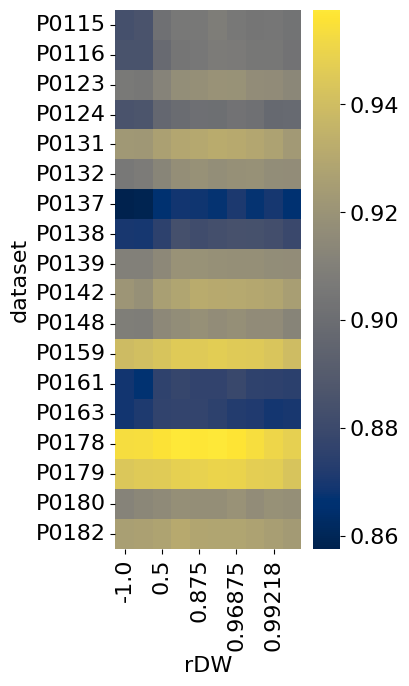

In [55]:
fig, ax = plt.subplots(figsize=[3,7])
table = all_results_avg[["rDW","dataset","CCpred_test"]].pivot_table(index='dataset', columns='rDW', values='CCpred_test')
sns.heatmap(table, cmap="cividis", ax=ax)
#ax.collections[0].set_clim(0.8,0.96)  

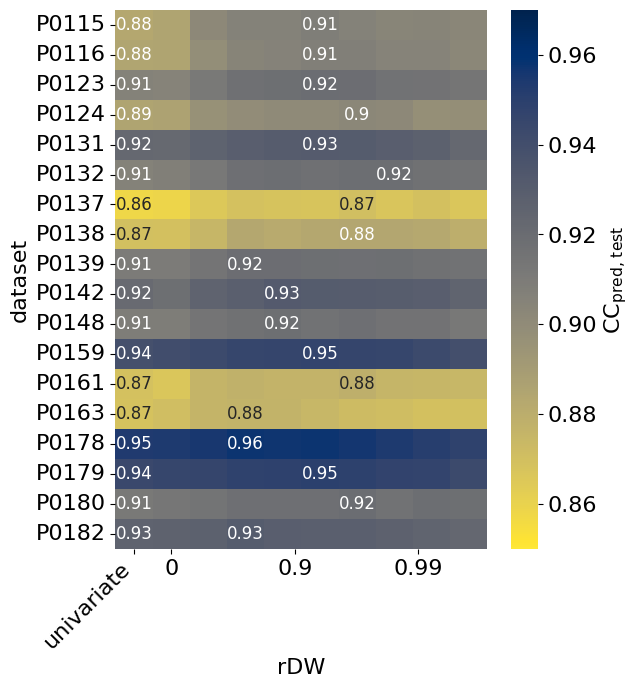

In [57]:
table = all_results_avg[["rDW","dataset","CCpred_test"]].pivot_table(index='dataset', columns='rDW', values='CCpred_test')
table.fillna(5, inplace=True) #diffmap peak heights are cut at 5sigma, so any NaNs are filled with value of 5. 
max_table = table.max(axis="columns").to_numpy()
table_div = table.div(max_table, axis='rows')


mask = table.eq(max_table, axis=0)
table_labels = table.where(mask).astype("float").round(2).fillna('')

table_labels[-1.0] = table.iloc[:,0]
table_labels = np.round(table_labels, 2)

fig = plt.figure(figsize=(11, 7))
gs = gridspec.GridSpec(1, 2, width_ratios=[0.6, 0.4])

ax1 = plt.subplot(gs[0])
sns.heatmap(table, ax=ax1, 
            cmap="cividis_r",
            cbar_kws={'label': r'CC$_\text{pred, test}$'},
            annot=table_labels,
            annot_kws={"fontsize":12},
            fmt = '')


xticks = (1.5-np.log2(1-np.array([-1,0,0.9,0.99])))/len(table.columns)
ax1.set_xticks(xticks*ax1.get_xlim()[1])
ax1.set_xticklabels(["univariate","0","0.9","0.99"])

ticks = ax1.get_xticklabels()
for ind,tick in enumerate(ticks):
    if ind == 0:
        tick.set_rotation(45)
        tick.set_ha("right")
    else:
        tick.set_rotation(0)

ax1.collections[0].set_clim(0.85,0.97) 
plt.savefig("CCpreds.svg",bbox_inches="tight")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


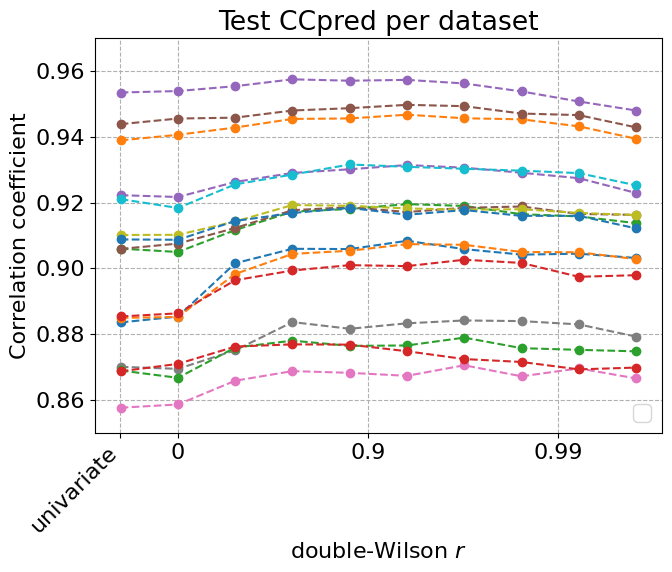

In [10]:
fig,ax = plt.subplots(figsize=(7,6))

#make a heatmap 


for i in range(16):
    plt.plot(np.log10(1-tmp[tmp["dataset"]==i]["rDW"]),tmp[tmp["dataset"]==i]["CCpred_test"],'o--') #,label=r"CC$_\text{pred, test}$")

plt.grid(linestyle="--")
plt.title("Test CCpred per dataset")
plt.legend(loc="lower right")
plt.xlabel("double-Wilson $r$")
plt.ylabel("Correlation coefficient")
plt.gca().invert_xaxis()
plt.xticks(ticks=[-2,-1,0,0.303],labels=["0.99","0.9","0","univariate"])
plt.ylim([0.85,0.97])
ticks = ax.get_xticklabels()
ticks[-1].set_rotation(45)
ticks[-1].set_ha("right")
#ax.legend(loc='lower right')
plt.tight_layout()
plt.savefig("CCs.svg",bbox_inches="tight")
plt.show()

The test CC_preds increase and then decrease as a function of double-Wilson r. 

In [11]:
count=0
results_list=[]
params_list=[]
id_list=[]


search_pattern="careless_runs"
for dirpath, dirnames, filenames in os.walk("."):
    if ('out_P0115_noweights_uv.csv' in filenames) and (search_pattern in dirpath):
       
        try:
            print(dirpath)
            tmp_id=int(dirpath.split('_')[-1])
            job_id=int(dirpath.split('_')[-7]) # appropriate index may vary from run to run!
            seed=int(dirpath.split('_')[-6])   # appropriate index may vary from run to run!
        except:
            print(dirpath.split('_')[-1])
        for j,holo in enumerate(dataset_names[:16]):
            stats = pd.read_csv(os.path.join(dirpath, f"out_{holo}_noweights_uv.csv"))
            heights = stats[stats["residue"]=="LIG"]
            #heights = heights["peakz"][:5].to_numpy().round(decimals=2)
            heights = tallest_pos_height(heights["peakz"][:5].to_numpy().round(decimals=2))
            
            tmp=pd.DataFrame({"heights":[heights],"dataset name":holo,
                              "grid_id":tmp_id,"job_id":job_id,
                              "seed":seed}, index=[j])
            results_list.append(tmp)
            
        print(f"Read-in values of grid_id: {tmp_id},  job_id: {job_id},  seed: {seed}")
        careless_params=get_careless_params(dirpath)
        careless_params["grid_id"]=tmp_id
        careless_params["job_id"]=job_id
        careless_params["seed"]=seed
        params_list.append(careless_params)


all_params =pd.concat(params_list)
all_heights = pd.concat(results_list)

./careless_runs/merge_20379811_3528_mono_mc1_10k_grid_9
Read-in values of grid_id: 9,  job_id: 20379811,  seed: 3528
./careless_runs/merge_20379920_12673_mono_mc1_10k_grid_11
Read-in values of grid_id: 11,  job_id: 20379920,  seed: 12673
./careless_runs/merge_20379915_20830_mono_mc1_10k_grid_6
Read-in values of grid_id: 6,  job_id: 20379915,  seed: 20830
./careless_runs/merge_20379917_9008_mono_mc1_10k_grid_7
Read-in values of grid_id: 7,  job_id: 20379917,  seed: 9008
./careless_runs/merge_20379919_22723_mono_mc1_10k_grid_10
Read-in values of grid_id: 10,  job_id: 20379919,  seed: 22723
./careless_runs/merge_20379913_17439_mono_mc1_10k_grid_4
Read-in values of grid_id: 4,  job_id: 20379913,  seed: 17439
./careless_runs/merge_20379914_10904_mono_mc1_10k_grid_5
Read-in values of grid_id: 5,  job_id: 20379914,  seed: 10904
./careless_runs/merge_20379918_5300_mono_mc1_10k_grid_2
Read-in values of grid_id: 2,  job_id: 20379918,  seed: 5300
./careless_runs/merge_20379916_11942_mono_mc1_10k_

In [12]:
all_params.reset_index(drop=True,inplace=True)
all_heights.dropna(inplace=True)
all_heights.sort_values(by=["grid_id","job_id"],inplace=True)
all_heights.reset_index(inplace=True)
all_heights.drop(columns="index", inplace=True)
print(all_heights.count())
all_heights.head()

heights         155
dataset name    155
grid_id         155
job_id          155
seed            155
dtype: int64


,heights,dataset name,grid_id,job_id,seed
0,28.10,P0115,2,20379918,5300
1,6.45,P0116,2,20379918,5300
2,6.19,P0123,2,20379918,5300
3,9.86,P0124,2,20379918,5300
4,13.27,P0131,2,20379918,5300


In [13]:
df_param=all_params[['IL','ITER','STDOF','PEF','rDW','RU','grid_id','job_id','seed']].copy()

for ix, row in df_param.iterrows():
    grid_id=int(row["grid_id"])
    job_id =int(row["job_id"])
    for column in df_param.columns:
        all_heights.loc[(all_heights["grid_id"]==grid_id) & (all_heights["job_id"]==job_id), column] =\
        df_param.loc[(df_param["grid_id"]==grid_id) & (df_param["job_id"]==job_id),column].to_numpy()[0]

all_heights=all_heights.infer_objects()
all_heights=all_heights.sort_values(by=["dataset name","rDW"])
all_heights=all_heights.reset_index()
all_heights=all_heights.drop(columns=["index"])


# plot the peak heights as a function of the double Wilson r

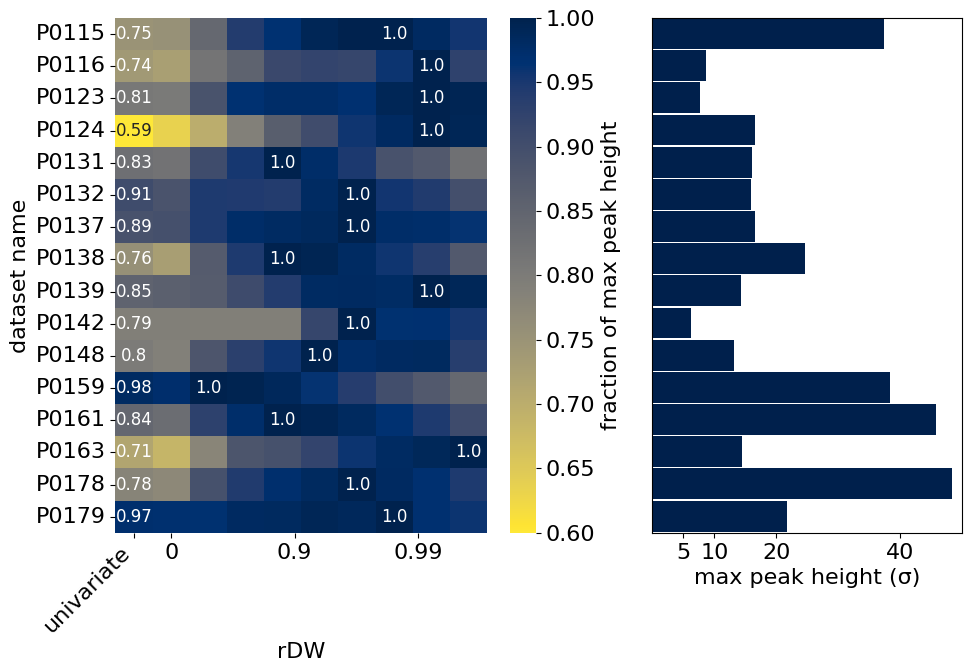

In [63]:
table = all_heights[["rDW","dataset name","heights"]].pivot_table(index='dataset name', columns='rDW', values='heights')
table.fillna(5, inplace=True) #diffmap peak heights are cut at 5sigma, so any NaNs are filled with value of 5. 
max_table = table.max(axis="columns").to_numpy()
table = table.div(max_table, axis='rows')


def threshold(x):
    return '' if x<1 else np.round(x,1)
table_labels = table.applymap(threshold)
table_labels[-1.0] = np.round(table.iloc[:,0],2)

fig = plt.figure(figsize=(10, 7))
gs = gridspec.GridSpec(1, 2, width_ratios=[0.6, 0.4])

ax1 = plt.subplot(gs[0])
sns.heatmap(table, ax=ax1, 
            cmap="cividis_r",
            cbar_kws={'label': 'fraction of max peak height'},
            annot=table_labels,
            annot_kws={"fontsize":12},
            fmt = '')


xticks = (1.5-np.log2(1-np.array([-1,0,0.9,0.99])))/len(table.columns)
ax1.set_xticks(xticks*ax1.get_xlim()[1])
ax1.set_xticklabels(["univariate","0","0.9","0.99"])

ticks = ax1.get_xticklabels()
for ind,tick in enumerate(ticks):
    if ind == 0:
        tick.set_rotation(45)
        tick.set_ha("right")
    else:
        tick.set_rotation(0)

ax1.collections[0].set_clim(0.6,1) 

ax2 = plt.subplot(gs[1], sharey=ax1)
ax2.barh(table.index, max_table, color='#00204c', height=0.96, align='edge')
ax2.tick_params(left=False, labelleft=False)
#ax2.set_xscale("log")
ax2.set_xlim([0,50])
ax2.set_xticks([5,10,20,40])
ax2.set_xticklabels([5,10,20,40])
ax2.set_xlabel('max peak height (σ)')
plt.tight_layout()
plt.savefig("peak_heights.svg",bbox_inches="tight")

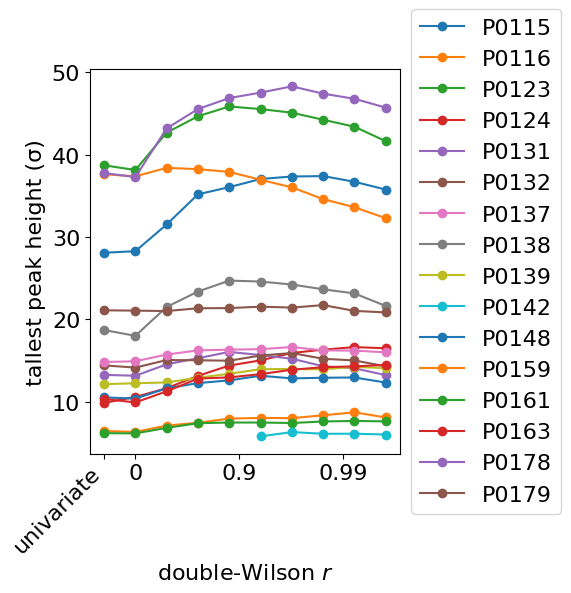

In [15]:

fig,ax = plt.subplots(figsize=(4,5))

for dataset in dataset_names[:16]:
    cut = all_heights[all_heights["dataset name"]==dataset]
    plt.plot(np.log10(1-cut.loc[:,"rDW"]),\
         cut.loc[:,"heights"],'o-',label=dataset)    
plt.xlabel("double-Wilson $r$")
plt.xticks(ticks=[-2,-1,0,0.303],labels=["0.99","0.9","0","univariate"])
ticks = ax.get_xticklabels()
ticks[-1].set_rotation(45)
ticks[-1].set_ha("right")
plt.ylabel("tallest peak height (σ)")
plt.gca().invert_xaxis()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("peakheights_unweighted_uv.svg",dpi=600,bbox_inches="tight")
plt.show()

### Save the grid_ids that correspond to the maximum peak height

In [16]:
max_height_indices = all_heights.groupby('dataset name')['heights'].idxmax()

# Get the corresponding parameters for the maximum height rows
result = all_heights.loc[max_height_indices, ['dataset name', 'grid_id','job_id']].reset_index(drop=True)
print(result)

try:
    os.mkdir("pymol_dfs")
except:
    pass

os.chdir("pymol_dfs")
univariate_dir = glob.glob(f"../careless_runs/merge_*_mono_mc1_10k_grid_2")[0]
for i,row in result.iterrows():
    mtz_dir = glob.glob(f"../careless_runs/merge_{row.job_id}_*_mono_mc1_10k_grid_{row.grid_id}")
    shutil.copy(f"{mtz_dir[0]}/wdm_{i+2}_uv.mtz", f"./wdm_{i+2}_best.mtz")
    shutil.copy(f"{univariate_dir}/wdm_{i+2}_uv.mtz",f"./wdm_{i+2}_univariate.mtz")
    shutil.copy(f"../20221007_unscaled_unmerged/UCSF-{row['dataset name']}/UCSF-{row['dataset name']}-pandda-model.pdb",
               f"UCSF-{row['dataset name']}-pandda-model_{i+2}.pdb")

   dataset name  grid_id    job_id
0         P0115        9  20379811
1         P0116       10  20379919
2         P0123       10  20379919
3         P0124       10  20379919
4         P0131        6  20379915
5         P0132        8  20379916
6         P0137        8  20379916
7         P0138        6  20379915
8         P0139       10  20379919
9         P0142        8  20379916
10        P0148        7  20379917
11        P0159        4  20379913
12        P0161        6  20379915
13        P0163       11  20379920
14        P0178        8  20379916
15        P0179        9  20379811


## write and execute pymol scripts for making images

In [17]:
for num, dataset in enumerate(dataset_names[:16]):
    careless_num = num+2
    os.system(f"sed 's/dataset=\"P0115\"/dataset=\"{dataset}\"/g' pymol_template.pml > pymol_{careless_num}.pml")
    os.system(f"sed -i 's/num=2/num={careless_num}/g' pymol_{careless_num}.pml")
    
    #on dataset 11, we make the difference map more clear by contouring at 2σ. 
    if careless_num == 11:
        os.system(f"sed -i 's/3.0, ligand/2.0, ligand/g' pymol_{careless_num}.pml")
        
    #on dataset 16, we set the view differently.     
    if careless_num == 16:
        os.system(f"sed -i 's/(-0.9199408888816833, 0.34247779846191406, -0.1907799392938614, -0.2290385514497757, -0.07459352910518646, 0.9705454111099243, 0.31816330552101135, 0.9365552067756653, 0.14706364274024963, 0.0, 0.0, -39.80332946777344, -44.95423126220703, -29.24036407470703, 2.3783278465270996, 34.238868713378906, 45.36779022216797, -20.0)/(0.15932810306549072, 0.7754020690917969, -0.611018180847168, -0.7061164379119873, 0.5220480561256409, 0.4783775210380554, 0.6899275183677673, 0.3552376925945282, 0.6307111382484436, 0.0, 0.0, -39.80332946777344, -44.78321075439453, -28.825420379638672, 0.8955264091491699, 35.08838653564453, 44.518272399902344, -20.0)/g' pymol_{careless_num}.pml")
    os.system(f"pymol pymol_{careless_num}.pml")

sh: pymol: command not found
sh: pymol: command not found
sh: pymol: command not found
sh: pymol: command not found
sh: pymol: command not found
sh: pymol: command not found
sh: pymol: command not found
sh: pymol: command not found
sh: pymol: command not found
sh: pymol: command not found
sh: pymol: command not found
sh: pymol: command not found
sh: pymol: command not found
sh: pymol: command not found
sh: pymol: command not found
sh: pymol: command not found
